# Assignment 02     
## CSCI S-96    
### Steve Elston

> **Instructions:** For this assignment you will complete the exercises shown. All exercises involve creating and executing some Python code. Additionally, most exercises have questions for you to answer. You can answer questions by creating a Markdown cell and writing your answer. If you are not familiar with Markdown, you can find a brief tutorial [here](https://www.markdownguide.org/cheat-sheet/).   

In this assignment you will work with some basic streaming analytic algorithms. To avoid the complexities of installing and setting up a real streaming analytics platform,you will work with stream flow data loaded from local files. Specifically in this assignment you will:    
1. Create and apply code to perform basic stream queries.    
2. Using stream queries and plots, explore the stream data.    
3. Use moving windows to compute moving averages and sub-sample a stream.    
4. Use exponential decay filters to compute moving averages and sub-sample a stream.    
5. Work with a quotient filter type filter to filter for customer identifiers on a list.   

## Overview 

The United States Geological Survey (USGS) maintains over 13,500 stream flow gages in the United States. Measurements from most of these gages are recoded every 15 min and uploaded every 4 hours are [available for download](https://waterdata.usgs.gov/nwis/rt). Stream flow data are used as inputs for complex water management tasks for purposes such as agriculture, residential use and conservation. For this assignment you will work with the time series of measurements for two stream flow gages on tributaries of the the Columbia River in the US State of Washington.     

To get started, execute the code in the cell below to import the packages you will need. 

In [260]:
import pandas as pd
import numpy as np
import numpy.random as nr
import mmh3
import math
import matplotlib.pyplot as plt

%matplotlib inline

## Loading the Dataset  

The next step is to load the stream gage data. The code in the cell below loads the time series data for the first gage. This gage is sited on the Okanogan river.  

The code in the cell below does the following:  
1. Loads the data from a .csv file. 
2. Converts the time stamp column to an index of the Pandas data frame. 
3. Assigns human-understandable names to the columns.  
4. Returns just the first 4 columns of the data frame. 

Execute this code and examine the results.

In [229]:
def read_index_series(file_name):  
    '''Function to read time series data from a file.
    Argument is the path and filename.'''
    df = pd.read_csv(file_name, sep='\t')
    df.index = df.datetime
    df.drop('datetime', axis=1, inplace=True)
    df = df.iloc[:,:4]
    df.columns = ['Agency', 'Site_number', 'Time_zone', 'Stream_flow']
    return df.iloc[:,:4]

Malott = read_index_series('../data/12447200_Okanogan_at_Malott.txt')
Malott

,Agency,Site_number,Time_zone,Stream_flow
datetime,,,,
2020-03-01 00:00,USGS,12447200,PST,2050
2020-03-01 00:15,USGS,12447200,PST,2050
2020-03-01 00:30,USGS,12447200,PST,2050
2020-03-01 00:45,USGS,12447200,PST,2050
2020-03-01 01:00,USGS,12447200,PST,2050
...,...,...,...,...
2020-08-31 22:45,USGS,12447200,PDT,1350
2020-08-31 23:00,USGS,12447200,PDT,1350
2020-08-31 23:15,USGS,12447200,PDT,1350


The other time series is for a gage on the Yakima River. Execute the code in the cell below and examine the result. 

In [230]:
CleElm = read_index_series('../data/12479500_Yakima_At_CleElm.txt')
CleElm

,Agency,Site_number,Time_zone,Stream_flow
datetime,,,,
2020-03-01 00:00,USGS,12484500,PST,1620
2020-03-01 00:15,USGS,12484500,PST,1620
2020-03-01 00:30,USGS,12484500,PST,1620
2020-03-01 00:45,USGS,12484500,PST,1620
2020-03-01 01:00,USGS,12484500,PST,1620
...,...,...,...,...
2020-08-31 22:45,USGS,12484500,PDT,3140
2020-08-31 23:00,USGS,12484500,PDT,3140
2020-08-31 23:15,USGS,12484500,PDT,3140


Since we really only want to work with one data frame. The code in the cell below merges the two time series and sorts them into time index order. Execute this code and examine the result, paying attention to the site number and the datetime index.  

In [231]:
stream_flow = Malott.append(CleElm).sort_index()
stream_flow

,Agency,Site_number,Time_zone,Stream_flow
datetime,,,,
2020-03-01 00:00,USGS,12447200,PST,2050
2020-03-01 00:00,USGS,12484500,PST,1620
2020-03-01 00:15,USGS,12484500,PST,1620
2020-03-01 00:15,USGS,12447200,PST,2050
2020-03-01 00:30,USGS,12447200,PST,2050
...,...,...,...,...
2020-08-31 23:15,USGS,12447200,PDT,1350
2020-08-31 23:30,USGS,12484500,PDT,3140
2020-08-31 23:30,USGS,12447200,PDT,1350


## Querying Stream Data

Common stream data operations are often formulated as queries on the stream data. Many streaming data platforms use extensions of SQL for these queries.   

To keep things simple in this assignment we will just use a simple query function. The function shown in the cell below supports simple queries on the    

In [232]:
def query_stream(df, Columns=None, site_numbers=None, start_time=None, end_time=None):    
    '''
    Function to query the stream gage time series data. The arguments are:    
    df = the data frame containing the data.  
    Columns = a list of columns to return.   
    site_numbers = a list of gage site numbers to query data. 
    start_time = the start time of the returned data as datatime string or integer index.   
    end_time = the end time of the returned data as datatime string or integer index.
    '''
    ## First set values for arguments set to Null  
    if Columns==None: Columns = df.columns
    if start_time==None: start_time = df.index[0]
    if end_time==None: end_time = df.index[df.shape[0]-1]
    if site_numbers==None: site_numbers = df.Site_number.unique()
    ## Test if index is a string datetime or an integer
    ## use iloc method if an integer.
    ## A slice over the time range is created based on the index type. 
    if isinstance(start_time, str):
        df = df.loc[start_time:end_time,:]
    else:     
        df = df.iloc[start_time:end_time,:]
    df = df.loc[df.Site_number.isin(site_numbers), Columns]
    ## Return the results of the query
    return df

You can see the options to run `query_stream` function by executing the code in the cell below. 

In [233]:
print(query_stream.__doc__)


    Function to query the stream gage time series data. The arguments are:    
    df = the data frame containing the data.  
    Columns = a list of columns to return.   
    site_numbers = a list of gage site numbers to query data. 
    start_time = the start time of the returned data as datatime string or integer index.   
    end_time = the end time of the returned data as datatime string or integer index.
    


An example of using the query function is shown in the cell below. Execute this code and examine the result. 

In [234]:
len(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500]))

17660

> **Exercise 02-01:** Using the `query_stream` function, write and execute the code in the cell below to compute and display the mean `Stream_flow`for the month of April of 2020 of site 1248500. Use the [Pandas.DataFrame.mean](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html) method to compute the mean. Notice that using this approach we can compute most any statistic of interest on the query result.    

In [235]:
## Put your code below


2238.241525423729

## Plotting Streaming Data

Visualization is important tool in data exploration and discovery. Numerical stream data is ideal for visual exploration if it can be subsampled to manageable size.  

The function in the cell below creates a time series plot. The time index of the Pandas data frame is used to generate the x-axis values. Execute the code in this cell to load this function.

In [236]:
def plot_time_series(df, ax=None, ylabel='Stream flow', title=''): 
    if ax==None: fig, ax = plt.subplots(figsize=(20, 6))
    df.plot(ax=ax);
    ax.set_xlabel('Date');
    ax.set_ylabel(ylabel);
    ax.set_title(title)
    plt.show()
    return ax    

The code in the cell below creates time series plots of the stream flow data. The flow time series for two stream gages queried as arguments to the plot function. Execute this code and examine the results. 

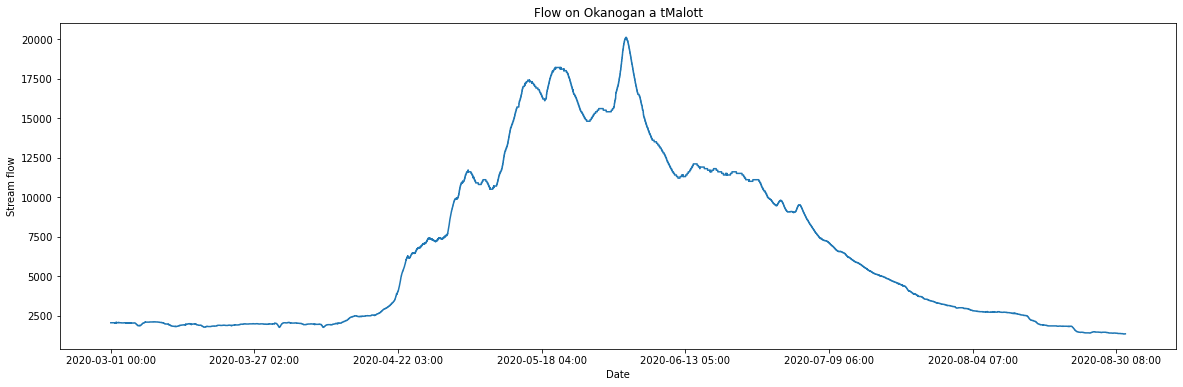

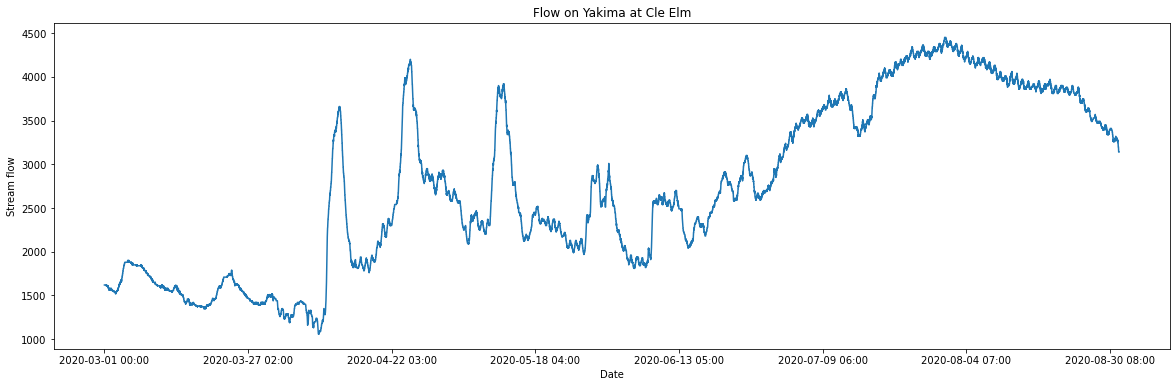

In [237]:
_=plot_time_series(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12447200]), title='Flow on Okanogan a tMalott') 
_=plot_time_series(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500]), title='Flow on Yakima at Cle Elm')    

The time series of stream flow at both of these gages is rather complex. Both rivers have several dams used to control the flow. The flow is optimized to conserve fisheries and to supply agriculture in the Columbia River Basin. Water in reservoirs accumulates in the spring as mountain snow melts. The water is then released throughout the spring and summer. 

But, what can we make of the noticeable spikes in flow, particularly for gage $12484500$ on the Yakima River. Even with the control provided by dams and reservoirs spring and early summer storm events can cause temporary increases in water flow. These storms bring heavy, and often warm, rain. Flow in the rivers increases not only because of the rainfall, but also since warm rain accelerates snow melt in the higher elevations.   

> **Exercise 02-02:** The transitory flow events on the Yakima River warrant some further investigation. You now have the tools to query and plot the stream flow time series. Your goal is to determine if there are common properties (e.g. duration or amplitude) of these events. Plot the results of a query for stream flows on gage $12484500$, Yakima River, from the 6th day of April to the 20th day of June, 2020. 

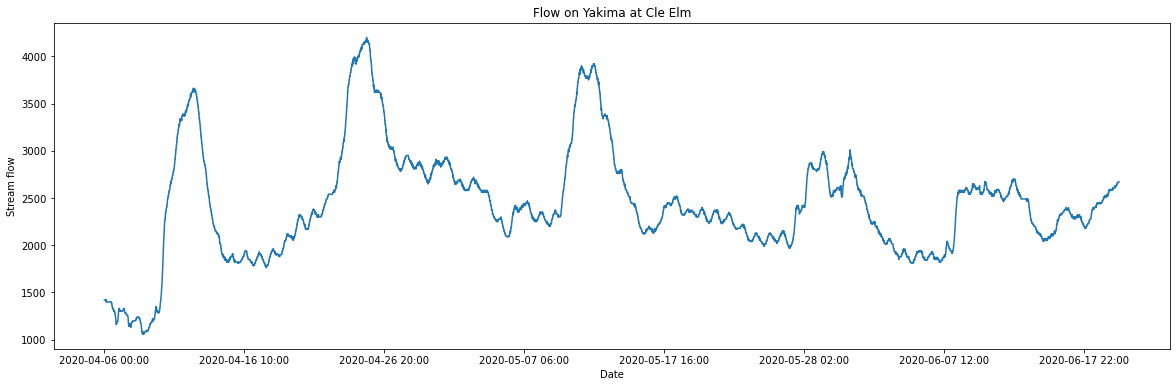

In [238]:
## Put your code below


> Discuss any common pattern in terms of approximately common amplitudes or durations of these events you can see.     

> **Answer:** 

## Applying Moving Window Filters

Moving window filters are a commonly used method to compute statistical samples from streaming data. 

Apply a moving window filter. 

> **Exercise 02-03:** You will complete and test the function in the cell below. The function queries a time series to create overlapping windows of a specified length and stride. For each window the mean of the stream flow is computed. The function returns a [Pandas Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) object. The time index of the Series object is the mid-point index of the window used to compute the statistic. 
> 1. Use a `for` loop to create the overlapping moving window samples of the input. The window will use the `length` and `stride` arguments to the function. At each iteration, the window will advance by `stride` time steps. See the [tutorial on the Python range function](https://www.w3schools.com/python/ref_func_range.asp) for help.    
>   - Query the input stream data for the stream flow values in the window. The `query_stream` function will accept integer indices for the `start_time` and `end_time` arguments. Make sure the these indicies are within the range of the original time series.  
>   - Append the mean of the stream flow values in the window to the `out` list.
>   - Append the time index of the midpoint of the window to the `idx` list.  
> 2. Once the loop has terminated used the [Pandas.Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html) constructor to instantiate the return series. 

In [239]:
def window_average(ts, length=16, stride=8, Columns='Stream_flow', site_numbers=[12484500]):
    half_length = int(length/2)-1
    idx = []
    out = []
    ## Put your code below
   




    out = pd.Series(out, index=idx)    
    return out     

> 3. Next you will test your function by completing and executing the code in the cell below. Use your `window_average` function to create a Pandas Series with 4-hour stream flow averages (length of 16 time steps), taken every 2 hours (stride of 8 time steps). Name your Series filtered_12 and compute and print the length. The code provided queries the data so that you are working with only values from the Yakima River gage. Using flow rate values from only one gage simplifies the bookkeeping for window sampling. 

In [240]:
## Query to create a series with only the Yakima River stream gage data. 

filtered_12 = window_average(Yakima)
len(filtered_12)

2206

> Notice how the length of the time series has been significantly reduced. Is the reduction in length of the time series consistent with a stride of 8 time steps?   
> **End of Exercise.**

> **Answer:**     

To examine the 4-hour moving average time series you have computed, execute the code in the cell below. 

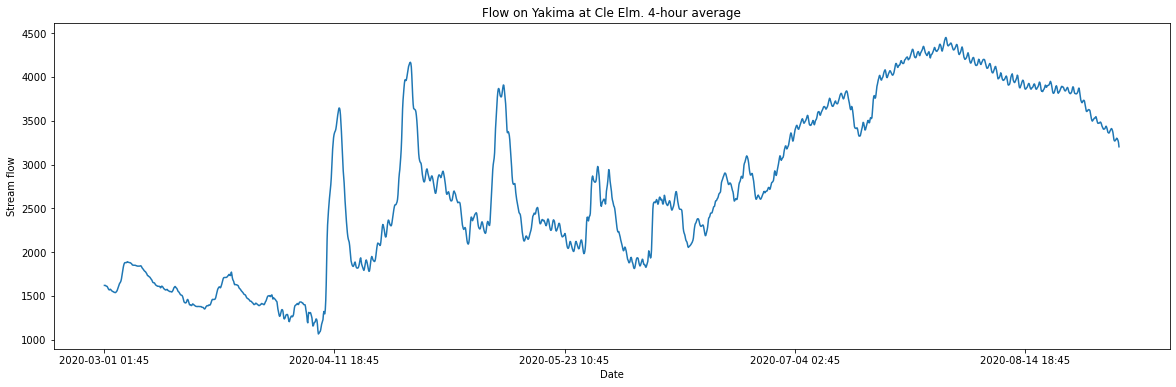

In [241]:
## Put your code below
_=plot_time_series(filtered_12, title='Flow on Yakima at Cle Elm. 4-hour average')

> **Exercise 02-4:** You will compute and display a time series using a longer, 1-day (96 time steps) moving window with a stride of 1/2 of a day (48 time steps). For this exercise, do the following:   
> 1. Query the Yakima River stream gage data with the longer time window and stride. 
> 2. Print the length of the resulting Pandas Series.  
> 3. Plot the moving average series.  

366


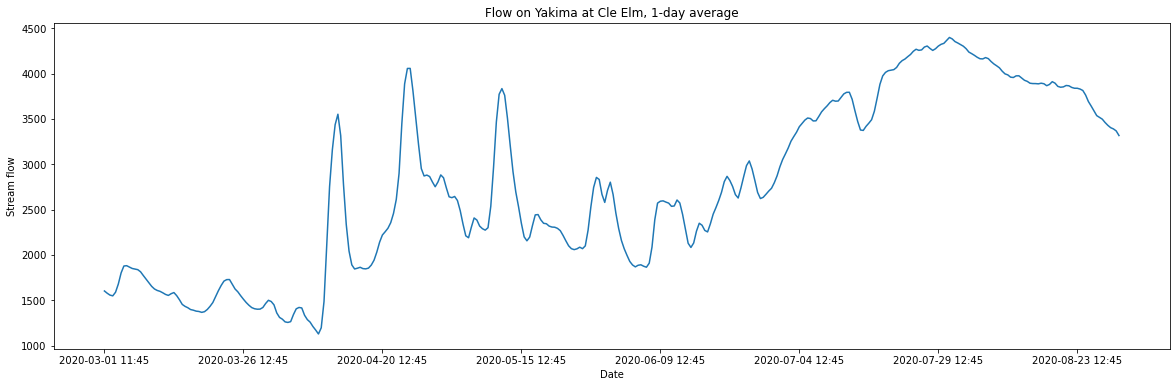

In [242]:
## Put your code below

print(len(filtered_96))
_=plot_time_series(filtered_96, title='Flow on Yakima at Cle Elm, 1-day average')

> Answer the following questions:   
> A. What is the data compression ratio of the longer time window? Is this consistent with the stride of the window?   
> B. Compare the plots of the results of the two moving window summaries. What are the obvious differences? 
> 3. If the goal is to measure total volume of water passing the gage on a daily and weekly basis, does the series from the longer filter contain sufficient detail? 

> **Answers:**     
> 1.          
> 2.     
> 3.                       

## Exponential Decay Filters

The idea of using exponential smooth for time series analysis is an old one, dating at least to use by Weiner in the 1920s. The related idea of moving average filters was developed by Kolmogorov and Zurbenko in the 1940s. Exponential smoothers were used extensively in signal process in the 1940s. The general idea was expanded by Robert Goodell Brown (1956) and C.E. Holt (1957) and his student P.R. Winters (1960). The higher-order Holt-Winters model accounts for trend and seasonality of time series.

### Basic exponential Smoothing

Exponential smoothing uses a weighted sum of the current observation and the past smoothed value to compute a new smoothed value. This basic exponential smoothing relationship is shown below.  

$$
s_0 = x_0 \\
s_t = \alpha x_t + (1-\alpha) s_{t-1} = s_{t-1} + \alpha(x_t - s_{t-1}),\ t \gt 0
$$

The smoothing hyperparameter, $\alpha$, controls the trade-off between the last observation and the previous smoothed values. The possible values are in the range, $0 \le \alpha \le 1$. A large value of $\alpha$ puts more weight on the current observation. Whereas, a small value of $\alpha$ puts more weight on the smoothed history.      

How can we understand the exponential decay of the smoothed history of a time series? The smoothing hyperparameter, $\alpha$, an be expressed in terms of the decay constant, $\tau$ and time interval $\Delta T$ as shown below.  

$$
\alpha = 1 - e^{\big( \frac{- \Delta T}{\tau} \big)}
$$

From this relationship you can see that the influence of the smoothed history decays exponentially as $\delta T$ increases. The decay time increases as $\tau$ decreases.   

### Smoothing with higher-order terms   

The basic exponential smoothing algorithm is effective in many cases. However, the simple first order exponential smoothing method cannot accommodate time series with trend or seasonality. Higher order smoothing models are required.   

The **double exponential smoothing** or **Holt-Winters double exponential smoothing** algorithm is a second order smoothing method. Using two coupled difference equations a trend and non-seasonal component of the time series can be modeled. The model updates a smoothed measure of the non-seasonal component and the trend.   

The model is initialized with the values:   
$$
s_1 = x_1 \\
b_1 = x_2 - x_1
$$

At each time step the a pair of time difference equations are updated. The following relationships update the smoothed non-seasonal component, $s_t$, and the slope, $b_t$:   

$$
s_t = \alpha x_t + (1-\alpha) (s_{t-1} + b_{t-1}) \\
b_t = \beta(s_t - s_{t-1}) + (1 - \beta)b_{t-1}
$$

The smoothed non-seasonal component and smoothed slope can be used to compute a forecast. The relationship below computes the forecast $m$ time steps ahead.      

$$ F_{t+m} = s_t + m b_t $$   

What about seasonal components? A third-order difference relationship can updated a smoothed seasonal component, along with the smoothed non-seasonal and slope components. The details of this process are not discussed further here. The details are available elsewhere, including the [exponential smoothing Wikipedia page](https://en.wikipedia.org/wiki/Exponential_smoothing#:~:text=Exponential%20smoothing%20is%20a%20rule,exponentially%20decreasing%20weights%20over%20time.).  

### Example of Exponential Decay Filtering     

> **Exercise 02-5:** You will now create and test an exponentially weighted decay filter. This function will have a stride argument just as the window filter function. Your function, `exponential_smooth`, will have arguments of the time series, the exponential smoothing parameter and a stride. Your function will do the following:    
> 1. Save the index of the incoming time series to a variable.   
> 2. Initialize the an empty index list for the output series.  
3. Initialize the value list for the samples. The samples list will contain the exponentially weighted smoothed samples. Make sure you save the first value in the list.   
> 4. Initialize an empty output value list.   
> 5. A for loop iterates over all the values of the time series starting with the second one. In this case a query is not used since for a live stream the exponential decay filter is updated each time a value arrives.    
>   - Append the computed exponentially weighted values smoothed values to the samples list. 
>   - If the loop index modulo the stride is 0 then, append the sample value to the output list and the index of that sample to the index list.  
> 8. Create an output Pandas Series from the output list and the output index list. 
> 9. Return the Pandas Series.  
> 10. Execute your function with for site number $12484500$ and default arguments of `alpha=0.01` and `stride=8`, 2 hours. 
> 11. Print the length the resulting series. 
> 12. Plot the series with the `plot_time_series` function. 

2207


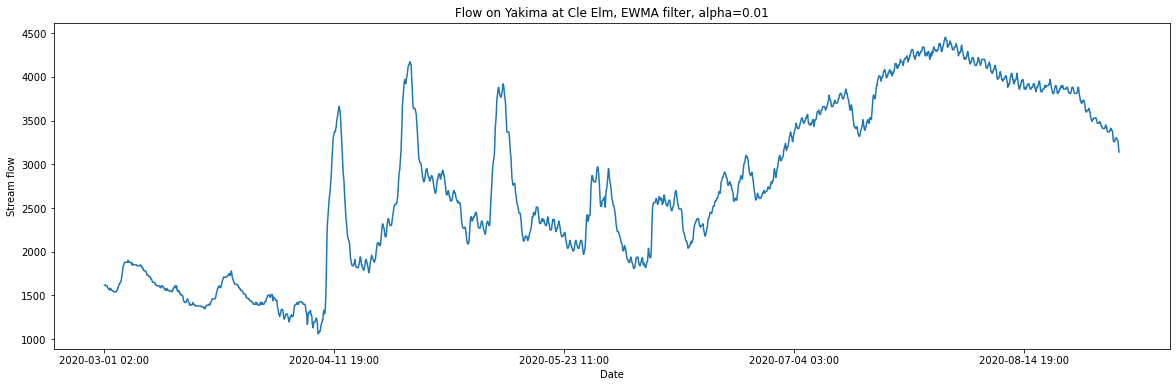

In [243]:
def exponential_smooth(ts, alpha=0.01, stride=8):
    in_index = ts.index
    idx = []
    samples=[ts[0]]
    out = []
    ## Put your code below
    
    
    
    
    
    return out       


smoothed_01 = exponential_smooth(query_stream(stream_flow, Columns='Stream_flow', site_numbers=[12484500]))

print(len(smoothed_01))
_=plot_time_series(smoothed_01, title='Flow on Yakima at Cle Elm, EWMA filter, alpha=0.01')

> Provide short answers to the following questions:   
> 1. Are the number of smoothed samples correct for the stride of the exponential decay filter selected?    
> 2. Are the details of the filtered time series substantially the same as the original series?  
> **End of exercise.** 

> **Answers:**    
> 1.       
> 2.     

> **Exercise 02-6:** A question we should ask is what happens if you increase the smoothing constant of the exponential decay filter? In other words, what is the effect of giving greater weight to past values? To find out do the following:  
> 1. Execute the `exponential_smooth` function with arguments `alpha=0.99` and `stride=8`.
> 2. Print the length of the resulting Pandas Series. 
> 3. Plot the smoothed time series using the `plot_time_series` function. 

2207


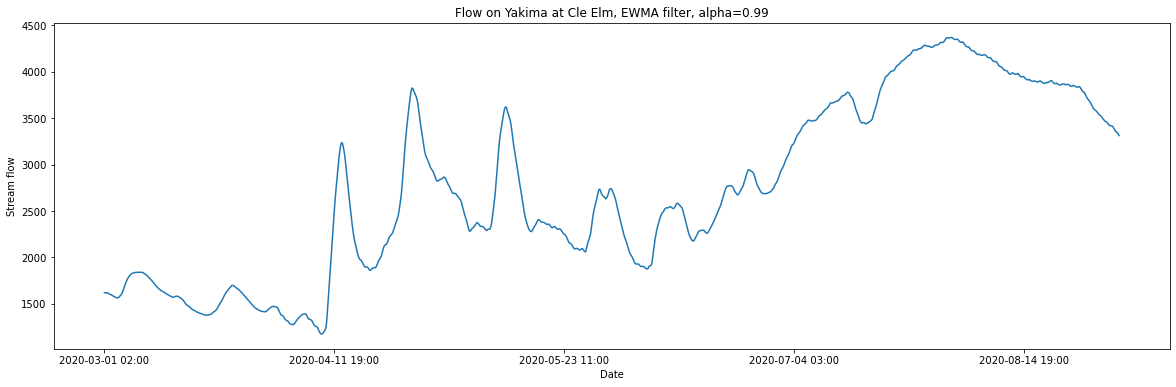

In [244]:
## Put your code below

print(len(smoothed_98))
_=plot_time_series(smoothed_98, title='Flow on Yakima at Cle Elm, EWMA filter, alpha=0.99')

> Compare the plot of this time series to the previous series less smoothing and provide short answers to the following questions.   
> 1. What is the main difference you can see between these series?    
> 2. WHy is this result expected from the theory?   
> **End of exercise.**

> **Answers:**   
> 1.       
> 2.     

> **Exercise 02-7:** The next question to ask is what is the effect of changing the stride? A longer stride reduces the number of smoothed samples used for further processing. To find out do the following:  
> 1. Execute the `exponential_smooth` function with arguments `alpha=0.99` and `stride=96`, one day or 24 hours.
> 2. Print the length of the resulting Pandas Series. 
> 3. Plot the smoothed time series using the `plot_time_series` function. 

183


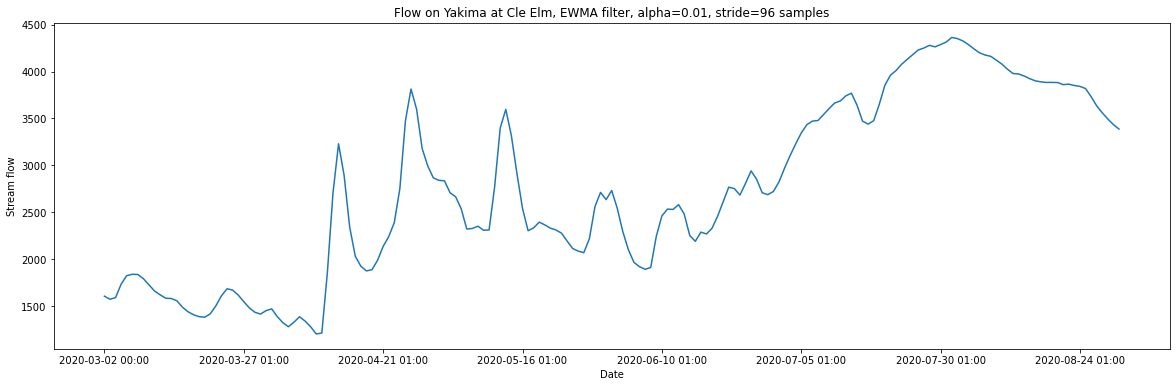

In [245]:
## Put your code below

print(len(smoothed_99))
_=plot_time_series(smoothed_99, title='Flow on Yakima at Cle Elm, EWMA filter, alpha=0.01, stride=96 samples')

> Provide short answers to the following questions. 
> 1. Compare the plot of this time series to the previous series with a shorter stride. What is the main difference you can see? 
> 2. Do you think any difference is significant in terms of managing water flow on a daily or weekly basis? 
> 3. Is the number of samples consistent with the stride defined?       
> **End of exercise.**

> **Answers:**           
> 1.       
> 2.        
> 3.     

## Filtering Events  

In many cases our goal is to filter events based on some type of identifier. The identifier is a hash of nearly any hashable data type. Many examples of these data types include, string customers identifiers, numeric event identifiers, IP addresses, email addresses.  

One example of such a method is the [**Bloom filter**](https://en.wikipedia.org/wiki/Bloom_filter). A Bloom filter is extremely  However, the Bloom filter does not allow for deleting matches once they are added to the hash table. An alternative is a **[quotient filter](https://en.wikipedia.org/wiki/Quotient_filter)**. The quotient filter keeps a count of events for each hash. As a result, an event identifier can be removed from the table by decrementing the counts for the hashes. To perform this extra operation the quotient filter uses more memory and is a bit less computationally efficient.   

Both Bloom filters and quotient filters operate by the same principle. A hash table of key-values pairs is created. The keys are the hashes of the event identifiers. For a Bloom filter 

In the following exercise, you will construct a simple filter similar to a quotient filter using a python dictionary for the hash table. Using this data structure consumes considerably more memory that an efficient implementation. However, using a dictionary will allow you to explore the concept of the quotient filter without the complexity of a production quality implementation.                      

### Instantiate the identifier lists      

To start the example, lists of customer identifiers are created. There is one list of customer identifiers and one list of identifiers of non-customers. Our goal is to constrict a hash filter that will differentiate customers from non-customers. 

The code in the cell below does the following:   
1. Defines the number of hashes in the hash table (dictionary) and a set of 3 prime number hash keys. There are three hash keys and we will use three hashes for inserts, deletes and look-ups in this example.     
2. Test that the number of hashes modulo the hash keys are all 0, to ensure the hash table will not be ragged increasing the probability of hash key collisions.     
3. Randomly generated lists of customer and non-customer ids are created. The customer and non-customer identifiers are all integers.   
4. The non-customer list is filtered to ensure there are no identifiers common with the customer list.  

Execute the code in the cell below.

In [246]:
number_of_hashes = 1024
hash_keys = [128,64,32]

nr.seed(4455)
customers = [int(8* number_of_hashes * i) for i in nr.uniform(size=50)]
not_customers = [int(8 * number_of_hashes * i) for i in nr.uniform(size=100)]

## Ensure there are no common ids between customers and non-customers
del_list = []
for i in range(len(not_customers)): 
    if not_customers[i] in customers: del_list.append(i)
for i in sorted(del_list, reverse=True):
    del not_customers[i]
    
## instantiate the empty hash dictionary    
hash_dict = dict([(i,0) for i in range(number_of_hashes)])

### Define a hash function

The quotient filter uses multiple hash values to reduce the probability of having The code in the cell below contains a simple modulo hash function along with some basic test cases. Execute this code and examine the results of the tests, making sure the hash keys (hash values) are unique and between 0 and `number_of_hashes`.  

In [247]:
def hash_function(i, hash_key, modulo=number_of_hashes):
    ## Put your code below. 
    return (i * hash_key) % modulo

for test_key in hash_keys: 
    print(hash_function(55555, test_key))

384
192
96


### Create and test insert and delete functions    

> **Exercise 2-8:** Event identifiers must be added and deleted from the hash table (dictionary) by their hash keys. For each identifier three hashes are computed. In each hash bucket (hashed key value) an integer 1 is added to the value. To complete the code in the cell below do the following: 
> 1. Use an iterator over the set of hash keys.  
> 2. For each key compute the hash value and use this to index a bucket in the hash table (the dictionary) and add 1 to the corresponding value.      
> Execute your code to create the empty hash table. 

In [248]:
def insert_event(id, hash_dictionary, keys): 
    ## Iterate over the set of keys, then for each key value
    ## compute the hash and add 1 to the bucket in the hash table.
    ## Place your code below
    
    
    return hash_dictionary

for id in customers: 
    hash_dict = insert_event(id, hash_dict, hash_keys)

> With the hash table filled with the valid customer IDs it is time to examine the details of the table. Ideally, we want the buckets that the identifiers hash into to be uniformly distributed. However, this is often not the case with simple hash functions. To visualize the counts by bucket (hash value) execute the code in the cell below and examine the results.

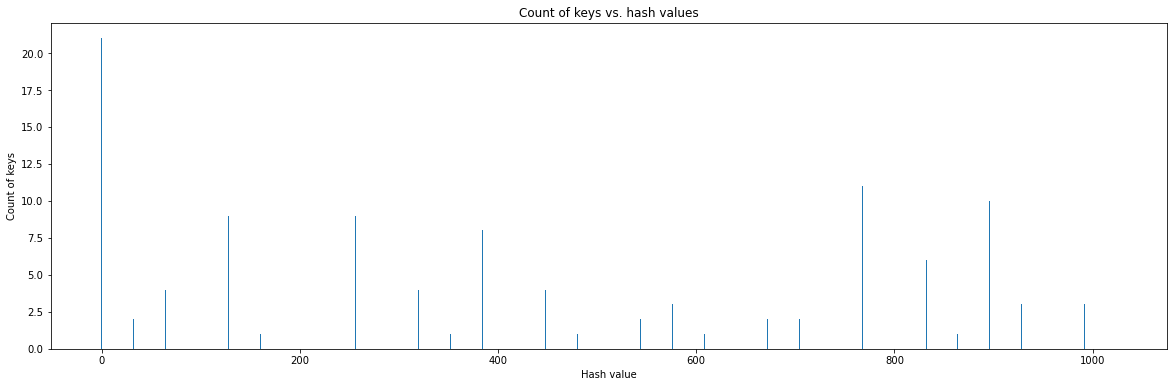

In [249]:
def plot_hash_keys(dictionary):
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.bar(dictionary.keys(), dictionary.values());
    ax.set_ylabel('Count of keys');
    ax.set_xlabel('Hash value');
    ax.set_title('Count of keys vs. hash values');
    
plot_hash_keys(hash_dict)    

> Examine the barplot of counts of hash values in the bins. Does this distribution look close to uniform, or do you think this is a poor hash function and why?    

> **Answer:**     

> There are several ways one can improve a hash function. Production quality systems use complex carefully designed hash functions. A simpler approach is to try prime numbers as the hash key. Choosing prime numbers reduces the chance of 'cyclic' behavior of the hash function which leads to lumpy hash values. To find out if this approach will help, execute the code in the cell below.  

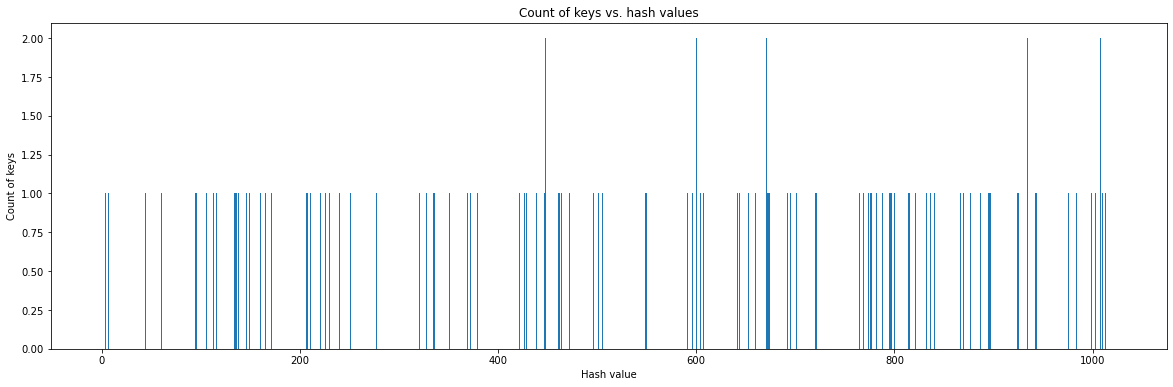

In [250]:
## instantiate the empty hash dictionary    
hash_dict = dict([(i,0) for i in range(number_of_hashes)])
## Prime number hash keys
hash_keys = [7873,5227,1009]
for id in customers: 
    hash_dict = insert_event(id, hash_dict, hash_keys)
    
plot_hash_keys(hash_dict) 

> Compare the bar chart of the hash function using prime modulo factors to the one using even binary numbers. Which set of hash functions is expected to give better false positive performance and why?  
> **End of exercise.**

> **Answer:**    

An advantage of a quotient filter like approach we are using for these exercises is that one can delete a key value since a count is maintained for each bucket in the hash table. The code in the cell below includes a delete function which is applied to the customer list. The table is then scanned to see if there are any non-zero values in the buckets. Execute this code and examine the results. 

In [251]:
def delete_event(id, hash_dictionary, keys): 
    for key in keys: 
        hash_dictionary[hash_function(id, key)] -= 1
    return hash_dictionary

for id in customers: 
    hash_dict = delete_event(id, hash_dict, hash_keys)
    
for key in hash_dict: 
    if hash_dict[key]!=0: print('Did not remove event id = ' + str(id))

It appears that the table is empty. This fact indicates that the add and delete functions operate correctly.  

### Apply the filter and test for false positive responses

The hash filter can be used to quickly determine if it contains an identifier value. The hashes of the identifier are tested to see if they are nonzero. if any of the buckets tested contain a zero value, the identifier is not in the table. If all buckets are nonzero, there are two possibilities. Either the identifier is in the table, or this is a false positive response. Recall that no false negative is possible with this scheme. The code in the cell below will count the false positive responses to the table of non-customers.    

> **Exercise 2-9:** The last component needed to complete the functionality is a look-up function to determine if an identifier is in the hash table. You will complete the code in the `is_in_hash` function in the cell below. The missing code in the function must do the following:    
> 1. Compute a list of hash values for the identifier using the `hash_key` list.     
> 2. Return `False` if the look-up of the value in the buckets for the hash values all contain 0. You can test the list using the Python [all](https://docs.python.org/3/library/functions.html#all) function. If all of the values in the buckets are not 0 then return true.   
> Execute your code.   

In [253]:
def is_in_hash(id, hash_dictionary, hash_keys):  
    ## Put your code below
   

    else: return True  

for id in customers:
    hash_dict = insert_event(id, hash_dict, hash_keys)

## Test that the     
false_positive_count = 0 
for id in not_customers: 
    if not is_in_hash(id, hash_dict, hash_keys): false_positive_count += 1
print('Number of false positives = ' + str(false_positive_count))                 

Number of false positives = 3


> For a perfect (uniform) hash function the theoretical false positive rate can be computed by the following relationship:  > $$P(false\ positive) = \Big[1 - exp \big(\frac{- k n}{m} \big) \Big]^k$$    
> Where, 
> - $k = $ number of hash functions.    
> - $m = $ length of the hash table.   
> - $n = $ number of identifiers in the hash table.   
> 
> In the cell below compute the theoretical probability a false positive for this exercise. Then multiply by the number of non-customers tested to find the expected number of false positives.   

In [255]:
## Put your code below
prob_of_false_positive = (1 - math.exp(-3*50/number_of_hashes))**3
prob_of_false_positive * 100

0.25299534706790944

> Compare the actual number of false positives to the expected number of false positives. Explain the difference.   
> **End of exercise:**

> **Answer:**   

> **Exercise 2-10:** There is one last bit of analysis that should be done. We have been using a somewhat arbitrary number of hash functions. But, it is possible to compute an optimal number of hash functions for an ideal situation using the following relationship, using the same notation used in Exercise 2-9:     
> $$k_{optimal} = \frac{m}{n} \big( log(2) \big)^2$$      
>      
> For $n = [50, 100, 200, 400]$ compute and print the optimal number of hashes, $k$.

In [259]:
## Put your code below



For 50 elements in the cache the optimal number of hashes = 9.839677725044764
For 100 elements in the cache the optimal number of hashes = 4.919838862522382
For 200 elements in the cache the optimal number of hashes = 2.459919431261191
For 400 elements in the cache the optimal number of hashes = 1.2299597156305955


> It is clear that for ideal hash functions we have been working with too few functions. However, there are several reasons why this ideal situation is not achieved. Consider two primary reasons that a smaller number of hash functions that the theoretical number might be better in a case like this, which include the clustering of the hash values and the fact that more than 50 identifiers in the hash table. State the reasons you can think of for using fewer hash functions.    
> **End of exercise.**

> **Answer:**     

#### Copyright, 2021, 2022, Stephen F Elston. All rights reserved. 